In [1]:
from codes.data_utils import set_seed

import codes.Spain.data_utils_spain
import codes.Spain.preprocess_covid_spain
import importlib
import codes.data_utils

importlib.reload(codes.Spain.data_utils_spain)
importlib.reload(codes.Spain.preprocess_covid_spain)
importlib.reload(codes.data_utils)

from codes.Spain.data_utils_spain import *
from codes.Spain.preprocess_covid_spain import *
from codes.data_utils import *

In [2]:
set_seed(42)
centrality_df = pd.read_csv("data/Spain/centrality_provinces.csv")

In [3]:
mobility_df = clean_spanish_mobility_data(
    file_path="data/Spain/Spanish-Mobility-Raw.xlsx",
    centrality_path="data/Spain/centrality_provinces.csv",
    save_path="data/Spain/mobility_cleaned_final.csv"
)

cities = sorted(set(mobility_df['origin']).union(set(mobility_df['destination'])))
cities_index = {cid: i for i, cid in enumerate(cities)}
N = len(cities)
print(f"Number of Cities: {N}")

avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['origin'], row['destination'], row['weight']
    avg_matrix.at[i, j] = w
    
print("Shape of avg_matrix:", avg_matrix.shape)

[✓] Final cleaned mobility data saved to: data/Spain/mobility_cleaned_final.csv
Number of Cities: 52
Shape of avg_matrix: (52, 52)


In [4]:
cities = sorted(centrality_df['nomemun'].unique())
avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['PROVINCIA ORIGEN'], row['PROVINCIA DESTINO'], row['weight']
    avg_matrix.at[i, j] = w

pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city.title().strip(), 0.0) for city in cities]

backbone_df = extract_backbone_from_avg_matrix(avg_matrix, cities, alpha=0.01, top_k=5)
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)

pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df.shape)
print(pyg_data)

[✓] Extracting backbone using pij < 0.01 and top-5 neighbors
[✓] Filtered down to 275 edges from 2478
[✓] Graph built with 52 nodes and 180 edges.
[✓] Converted to PyTorch Geometric format.
Backbone extracted with 275 edges
(275, 7)
Data(edge_index=[2, 360], weight=[360], edge_attr=[360, 1], num_nodes=52, x=[52, 1])


In [5]:
# Normalize edges so (A, B) and (B, A) are treated the same
normalized_edges = backbone_df.apply(
    lambda row: tuple(sorted([row['source'], row['target']])), axis=1
)

num_unique_edges = len(set(normalized_edges))
print(f"Unique undirected edges: {num_unique_edges}")

Unique undirected edges: 180


In [6]:
df_covid = pd.read_csv("data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv")
filtered_covid_df = filter_and_scale_spanish_covid_by_centrality(df_covid)

city_case_counts = filtered_covid_df['cod_ine'].value_counts().sort_index()
print(filtered_covid_df.head(100000))

[✓] Filtered to 52 provinces, 40,872 rows.
[✓] Applied Z-score normalization on daily cases (Casos).
[✓] Saved filtered + scaled Spanish COVID data to 'data/Spain/filtered_scaled_covid.csv'.
            Fecha  cod_ine         provincia  Casos  Fallecidos  \
0      2020-01-01        0         No consta      0           0   
1      2020-01-01        1       Araba/Álava      0           0   
2      2020-01-01        2          Albacete      0           0   
3      2020-01-01        3  Alicante/Alacant      0           0   
4      2020-01-01        4           Almería      0           0   
...           ...      ...               ...    ...         ...   
41652  2022-02-24       47        Valladolid      0           0   
41653  2022-02-24       48           Bizkaia     15           0   
41654  2022-02-24       49            Zamora      0           0   
41655  2022-02-24       50          Zaragoza      0           0   
41656  2022-02-24       51             Ceuta      0           0   

    

In [7]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [72]:
# Rename columns for compatibility
spain_covid_df = (
    filtered_covid_df
    .rename(columns={"cod_ine": "ibgeID", "Fecha": "date"})  # 🔁 Rename to match expected schema
)

# Step 1: Get total number of unique time steps
unique_dates = spain_covid_df['date'].sort_values().unique()
cutoff_idx = int(len(unique_dates) * 0.8)
cutoff_date = unique_dates[cutoff_idx]

# Step 2: Filter the DataFrame to remove last 20% of dates
spain_covid_df_cut = spain_covid_df[spain_covid_df['date'] < cutoff_date]

X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    spain_covid_df_cut,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.8
)

[✓] Sliding window: X torch.Size([614, 14, 52, 1]), Y torch.Size([614, 1, 52, 1])
[✓] Train: torch.Size([491, 14, 52, 1]), Test: torch.Size([123, 14, 52, 1])


In [73]:
import codes.models.custom_gcn_transformer_parallel
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet

N = pyg_data.num_nodes

model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=0,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=64,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

# model.static_node_features = pyg_data.x.to(device)
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  # reduce LR by half every 5 epochs

In [74]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [75]:
batch_size = 128  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [76]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [77]:
from tqdm import tqdm

num_epochs = 60
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}", position=0, leave=True)

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)  # from [B, 1, N, 1] → [B, N, 1]

        optimizer.zero_grad()
        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']

        # Live update of progress bar
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "LR": f"{current_lr:.6f}"
        })

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    scheduler.step()

🧠 Epoch 1/60: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it, Loss=0.1753, LR=0.001000]


✅ Epoch 1/60 — Avg Loss: 0.2690


🧠 Epoch 2/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0841, LR=0.001000]


✅ Epoch 2/60 — Avg Loss: 0.1348


🧠 Epoch 3/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0402, LR=0.001000]


✅ Epoch 3/60 — Avg Loss: 0.0753


🧠 Epoch 4/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0468, LR=0.001000]


✅ Epoch 4/60 — Avg Loss: 0.0538


🧠 Epoch 5/60: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, Loss=0.0479, LR=0.001000]


✅ Epoch 5/60 — Avg Loss: 0.0474


🧠 Epoch 6/60: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it, Loss=0.0436, LR=0.000700]


✅ Epoch 6/60 — Avg Loss: 0.0449


🧠 Epoch 7/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0542, LR=0.000700]


✅ Epoch 7/60 — Avg Loss: 0.0440


🧠 Epoch 8/60: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it, Loss=0.0439, LR=0.000700]


✅ Epoch 8/60 — Avg Loss: 0.0403


🧠 Epoch 9/60: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, Loss=0.0326, LR=0.000700]


✅ Epoch 9/60 — Avg Loss: 0.0392


🧠 Epoch 10/60: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, Loss=0.0343, LR=0.000700]


✅ Epoch 10/60 — Avg Loss: 0.0372


🧠 Epoch 11/60: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, Loss=0.0416, LR=0.000490]


✅ Epoch 11/60 — Avg Loss: 0.0355


🧠 Epoch 12/60: 100%|██████████| 4/4 [00:05<00:00,  1.38s/it, Loss=0.0433, LR=0.000490]


✅ Epoch 12/60 — Avg Loss: 0.0350


🧠 Epoch 13/60: 100%|██████████| 4/4 [00:07<00:00,  1.80s/it, Loss=0.0452, LR=0.000490]


✅ Epoch 13/60 — Avg Loss: 0.0338


🧠 Epoch 14/60: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, Loss=0.0348, LR=0.000490]


✅ Epoch 14/60 — Avg Loss: 0.0326


🧠 Epoch 15/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0327, LR=0.000490]


✅ Epoch 15/60 — Avg Loss: 0.0321


🧠 Epoch 16/60: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it, Loss=0.0324, LR=0.000343]


✅ Epoch 16/60 — Avg Loss: 0.0318


🧠 Epoch 17/60: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it, Loss=0.0301, LR=0.000343]


✅ Epoch 17/60 — Avg Loss: 0.0313


🧠 Epoch 18/60: 100%|██████████| 4/4 [00:05<00:00,  1.48s/it, Loss=0.0240, LR=0.000343]


✅ Epoch 18/60 — Avg Loss: 0.0312


🧠 Epoch 19/60: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it, Loss=0.0239, LR=0.000343]


✅ Epoch 19/60 — Avg Loss: 0.0306


🧠 Epoch 20/60: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it, Loss=0.0327, LR=0.000343]


✅ Epoch 20/60 — Avg Loss: 0.0306


🧠 Epoch 21/60: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it, Loss=0.0341, LR=0.000240]


✅ Epoch 21/60 — Avg Loss: 0.0304


🧠 Epoch 22/60: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it, Loss=0.0365, LR=0.000240]


✅ Epoch 22/60 — Avg Loss: 0.0306


🧠 Epoch 23/60: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it, Loss=0.0360, LR=0.000240]


✅ Epoch 23/60 — Avg Loss: 0.0306


🧠 Epoch 24/60: 100%|██████████| 4/4 [00:06<00:00,  1.52s/it, Loss=0.0221, LR=0.000240]


✅ Epoch 24/60 — Avg Loss: 0.0297


🧠 Epoch 25/60: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it, Loss=0.0366, LR=0.000240]


✅ Epoch 25/60 — Avg Loss: 0.0303


🧠 Epoch 26/60: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it, Loss=0.0341, LR=0.000168]


✅ Epoch 26/60 — Avg Loss: 0.0298


🧠 Epoch 27/60: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it, Loss=0.0220, LR=0.000168]


✅ Epoch 27/60 — Avg Loss: 0.0292


🧠 Epoch 28/60: 100%|██████████| 4/4 [00:06<00:00,  1.73s/it, Loss=0.0234, LR=0.000168]


✅ Epoch 28/60 — Avg Loss: 0.0293


🧠 Epoch 29/60: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, Loss=0.0313, LR=0.000168]


✅ Epoch 29/60 — Avg Loss: 0.0296


🧠 Epoch 30/60: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it, Loss=0.0303, LR=0.000168]


✅ Epoch 30/60 — Avg Loss: 0.0295


🧠 Epoch 31/60: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it, Loss=0.0228, LR=0.000118]


✅ Epoch 31/60 — Avg Loss: 0.0293


🧠 Epoch 32/60: 100%|██████████| 4/4 [00:05<00:00,  1.46s/it, Loss=0.0222, LR=0.000118]


✅ Epoch 32/60 — Avg Loss: 0.0287


🧠 Epoch 33/60: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it, Loss=0.0219, LR=0.000118]


✅ Epoch 33/60 — Avg Loss: 0.0294


🧠 Epoch 34/60: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, Loss=0.0325, LR=0.000118]


✅ Epoch 34/60 — Avg Loss: 0.0294


🧠 Epoch 35/60: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it, Loss=0.0337, LR=0.000118]


✅ Epoch 35/60 — Avg Loss: 0.0291


🧠 Epoch 36/60: 100%|██████████| 4/4 [00:06<00:00,  1.53s/it, Loss=0.0352, LR=0.000082]


✅ Epoch 36/60 — Avg Loss: 0.0293


🧠 Epoch 37/60: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it, Loss=0.0239, LR=0.000082]


✅ Epoch 37/60 — Avg Loss: 0.0290


🧠 Epoch 38/60: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it, Loss=0.0326, LR=0.000082]


✅ Epoch 38/60 — Avg Loss: 0.0290


🧠 Epoch 39/60: 100%|██████████| 4/4 [00:05<00:00,  1.45s/it, Loss=0.0330, LR=0.000082]


✅ Epoch 39/60 — Avg Loss: 0.0292


🧠 Epoch 40/60: 100%|██████████| 4/4 [00:05<00:00,  1.41s/it, Loss=0.0279, LR=0.000082]


✅ Epoch 40/60 — Avg Loss: 0.0288


🧠 Epoch 41/60: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it, Loss=0.0335, LR=0.000058]


✅ Epoch 41/60 — Avg Loss: 0.0291


🧠 Epoch 42/60: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it, Loss=0.0279, LR=0.000058]


✅ Epoch 42/60 — Avg Loss: 0.0287


🧠 Epoch 43/60: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it, Loss=0.0251, LR=0.000058]


✅ Epoch 43/60 — Avg Loss: 0.0287


🧠 Epoch 44/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0315, LR=0.000058]


✅ Epoch 44/60 — Avg Loss: 0.0290


🧠 Epoch 45/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0236, LR=0.000058]


✅ Epoch 45/60 — Avg Loss: 0.0287


🧠 Epoch 46/60: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, Loss=0.0299, LR=0.000040]


✅ Epoch 46/60 — Avg Loss: 0.0289


🧠 Epoch 47/60: 100%|██████████| 4/4 [00:05<00:00,  1.36s/it, Loss=0.0363, LR=0.000040]


✅ Epoch 47/60 — Avg Loss: 0.0291


🧠 Epoch 48/60: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, Loss=0.0304, LR=0.000040]


✅ Epoch 48/60 — Avg Loss: 0.0288


🧠 Epoch 49/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0253, LR=0.000040]


✅ Epoch 49/60 — Avg Loss: 0.0283


🧠 Epoch 50/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0323, LR=0.000040]


✅ Epoch 50/60 — Avg Loss: 0.0288


🧠 Epoch 51/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0314, LR=0.000028]


✅ Epoch 51/60 — Avg Loss: 0.0286


🧠 Epoch 52/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0341, LR=0.000028]


✅ Epoch 52/60 — Avg Loss: 0.0289


🧠 Epoch 53/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0270, LR=0.000028]


✅ Epoch 53/60 — Avg Loss: 0.0288


🧠 Epoch 54/60: 100%|██████████| 4/4 [00:05<00:00,  1.31s/it, Loss=0.0253, LR=0.000028]


✅ Epoch 54/60 — Avg Loss: 0.0285


🧠 Epoch 55/60: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it, Loss=0.0236, LR=0.000028]


✅ Epoch 55/60 — Avg Loss: 0.0286


🧠 Epoch 56/60: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it, Loss=0.0343, LR=0.000020]


✅ Epoch 56/60 — Avg Loss: 0.0289


🧠 Epoch 57/60: 100%|██████████| 4/4 [00:05<00:00,  1.34s/it, Loss=0.0231, LR=0.000020]


✅ Epoch 57/60 — Avg Loss: 0.0281


🧠 Epoch 58/60: 100%|██████████| 4/4 [00:05<00:00,  1.42s/it, Loss=0.0290, LR=0.000020]


✅ Epoch 58/60 — Avg Loss: 0.0287


🧠 Epoch 59/60: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, Loss=0.0369, LR=0.000020]


✅ Epoch 59/60 — Avg Loss: 0.0288


🧠 Epoch 60/60: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it, Loss=0.0256, LR=0.000020]

✅ Epoch 60/60 — Avg Loss: 0.0285


In [23]:
model.load_state_dict(torch.load("models/GCN-GCN-Transformer-Spain-BEST-BEST.pth"))
model.eval()  # Optional but good practice for inference

SpatioTemporalFusionNet(
  (temporal_encoder): TemporalTransformer(
    (proj): Linear(in_features=1, out_features=64, bias=True)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (fusion): FusionAttention(
    (query): Linear(in_features=64, out_features=64, bias=True)
    (key): Linear(in_features=64, out_feat

In [78]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")


🔍 Testing:   0%|          | 0/1 [00:00<?, ?it/s]/Users/youssefmalek/miniconda3/envs/ML/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([123, 1, 52, 1])) that is different to the input size (torch.Size([123, 52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
                                                                     


✅ Final Test Loss: 0.2543


In [79]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()
pred_array = predictions.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array.shape)
print("Actual shape:", actual_array.shape)

Pred shape: (123, 52)
Actual shape: (123, 52)


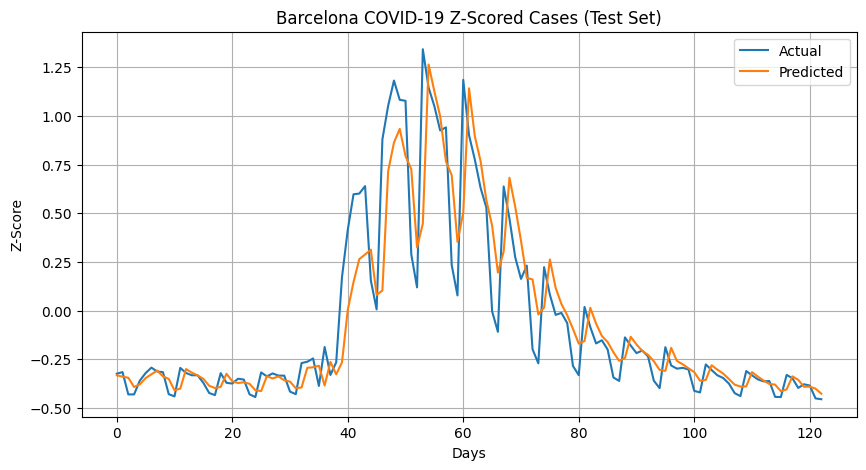

📉 RMSE for Barcelona: 0.1999
📉 SMAPE for Barcelona: 22.32%
📈 MDA for Barcelona: 68.03%


In [80]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array[:, barcelona_index]
barcelona_actuals = actual_array[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_barcelona = smape(barcelona_actuals, barcelona_preds)
print(f"📉 SMAPE for Barcelona: {smape_barcelona:.2f}%")

mda_barcelona = mean_directional_accuracy(barcelona_actuals, barcelona_preds)
print(f"📈 MDA for Barcelona: {mda_barcelona:.2f}%")

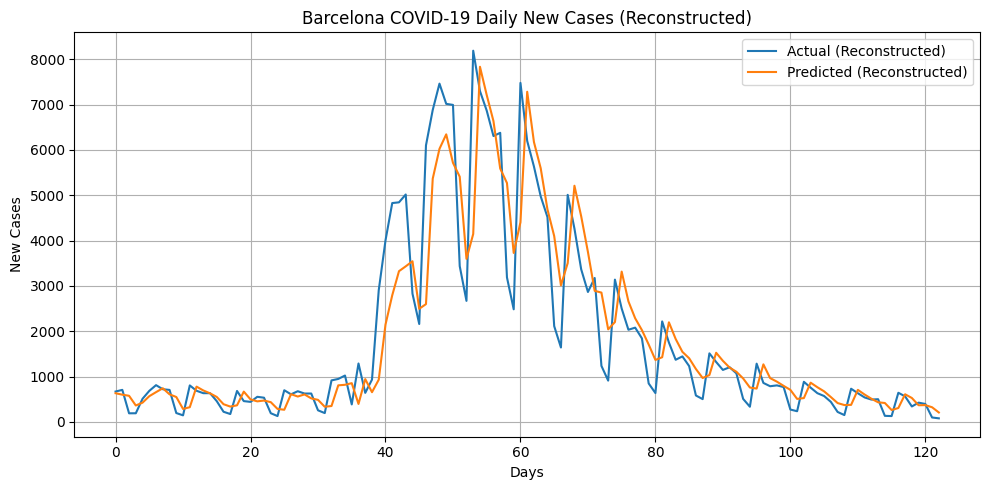

📉 RMSE for Barcelona: 901.9415
📉 SMAPE for Barcelona: 19.07%


In [81]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph from centrality dataframe
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_name = row['nomemun']
    G2.add_node(city_name)

# Make sure predictions and actuals are [T, N]
pred_array = predictions.squeeze(-1).numpy()        # [T, N]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()  # [T, N]

# Barcelona node name
city_name = "Barcelona"
city_id_list = list(G2.nodes())
barcelona_index = city_id_list.index(city_name)

# Get z-scored predictions and actuals
barcelona_preds_z = pred_array[:, barcelona_index]
barcelona_actuals_z = actual_array[:, barcelona_index]

# 🧠 Reconstruct actual daily cases
sp_original = df_covid[df_covid['provincia'] == city_name].copy()
sp_original['Casos'] = sp_original['Casos'].clip(lower=0)
sp_original = sp_original.sort_values('Fecha')

mean_barcelona = sp_original['Casos'].mean()
std_barcelona = sp_original['Casos'].std(ddof=0)

# 🔁 De-normalize predictions
barcelona_preds = barcelona_preds_z * std_barcelona + mean_barcelona
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual (Reconstructed)')
plt.plot(barcelona_preds, label='Predicted (Reconstructed)')
plt.title("Barcelona COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

smape_barcelona = smape(barcelona_actuals, barcelona_preds)
print(f"📉 SMAPE for Barcelona: {smape_barcelona:.2f}%")


In [82]:
# Filter São Paulo full series
sp_full = filtered_covid_df[filtered_covid_df['provincia'] == city_name].sort_values('Fecha')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['Fecha'].tolist()

In [83]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")


📊 Average RMSE across all cities: 0.1498
📊 Average SMAPE across all cities: 24.40%


In [84]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: A Coruña — RMSE: 0.3297
City ID: Bizkaia — RMSE: 0.3188
City ID: Lleida — RMSE: 0.2789
City ID: Zamora — RMSE: 0.2649
City ID: Granada — RMSE: 0.2537

✅ Top 5 cities with lowest RMSE:
City ID: Lugo — RMSE: 0.0691
City ID: Girona — RMSE: 0.0694
City ID: Castellón/Castelló — RMSE: 0.0777
City ID: Valladolid — RMSE: 0.0789
City ID: Albacete — RMSE: 0.0827


In [85]:
# Pair cities with their SMAPE values
city_smape_pairs = list(zip(city_id_list, smapes))
sorted_city_smapes = sorted(city_smape_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest SMAPE:")
for city_id, smape_val in sorted_city_smapes[-5:][::-1]:
    print(f"City: {city_id} — SMAPE: {smape_val:.2f}%")

print("\n✅ Top 5 cities with lowest SMAPE:")
for city_id, smape_val in sorted_city_smapes[:5]:
    print(f"City: {city_id} — SMAPE: {smape_val:.2f}%")



🔝 Top 5 cities with highest SMAPE:
City: Segovia — SMAPE: 42.09%
City: Huelva — SMAPE: 38.64%
City: Córdoba — SMAPE: 38.13%
City: Granada — SMAPE: 37.04%
City: Ávila — SMAPE: 34.02%

✅ Top 5 cities with lowest SMAPE:
City: Girona — SMAPE: 16.46%
City: Madrid — SMAPE: 16.52%
City: Ourense — SMAPE: 17.26%
City: Cuenca — SMAPE: 17.47%
City: Valladolid — SMAPE: 17.76%


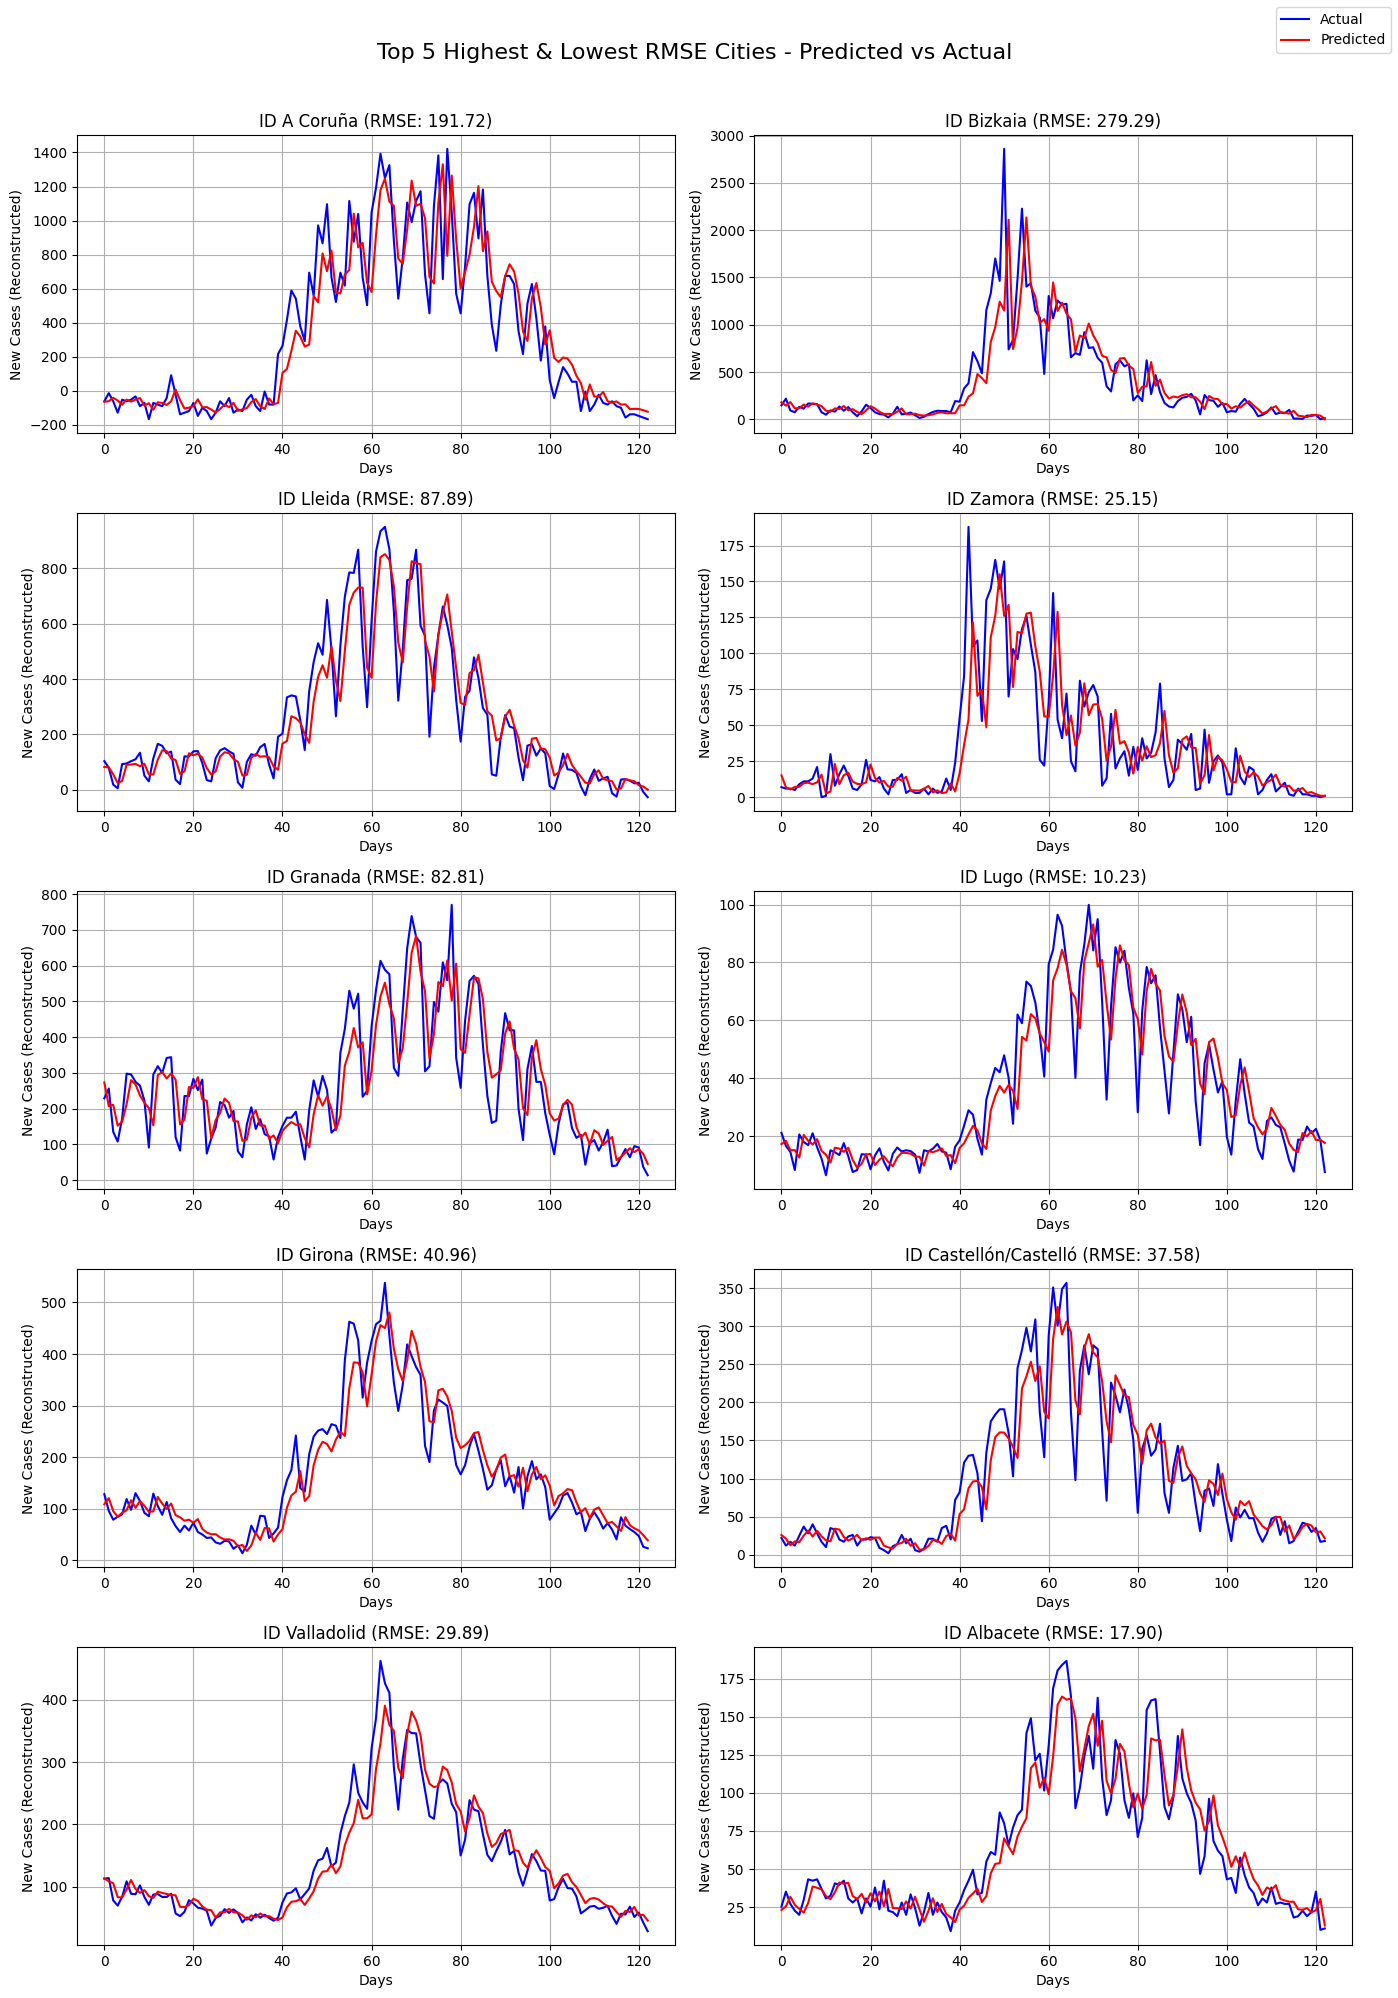

In [86]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = df_covid[df_covid['provincia'] == city_id].copy()
    city_data['Casos'] = city_data['Casos'].clip(lower=0)
    mean = city_data['Casos'].mean()
    std = city_data['Casos'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


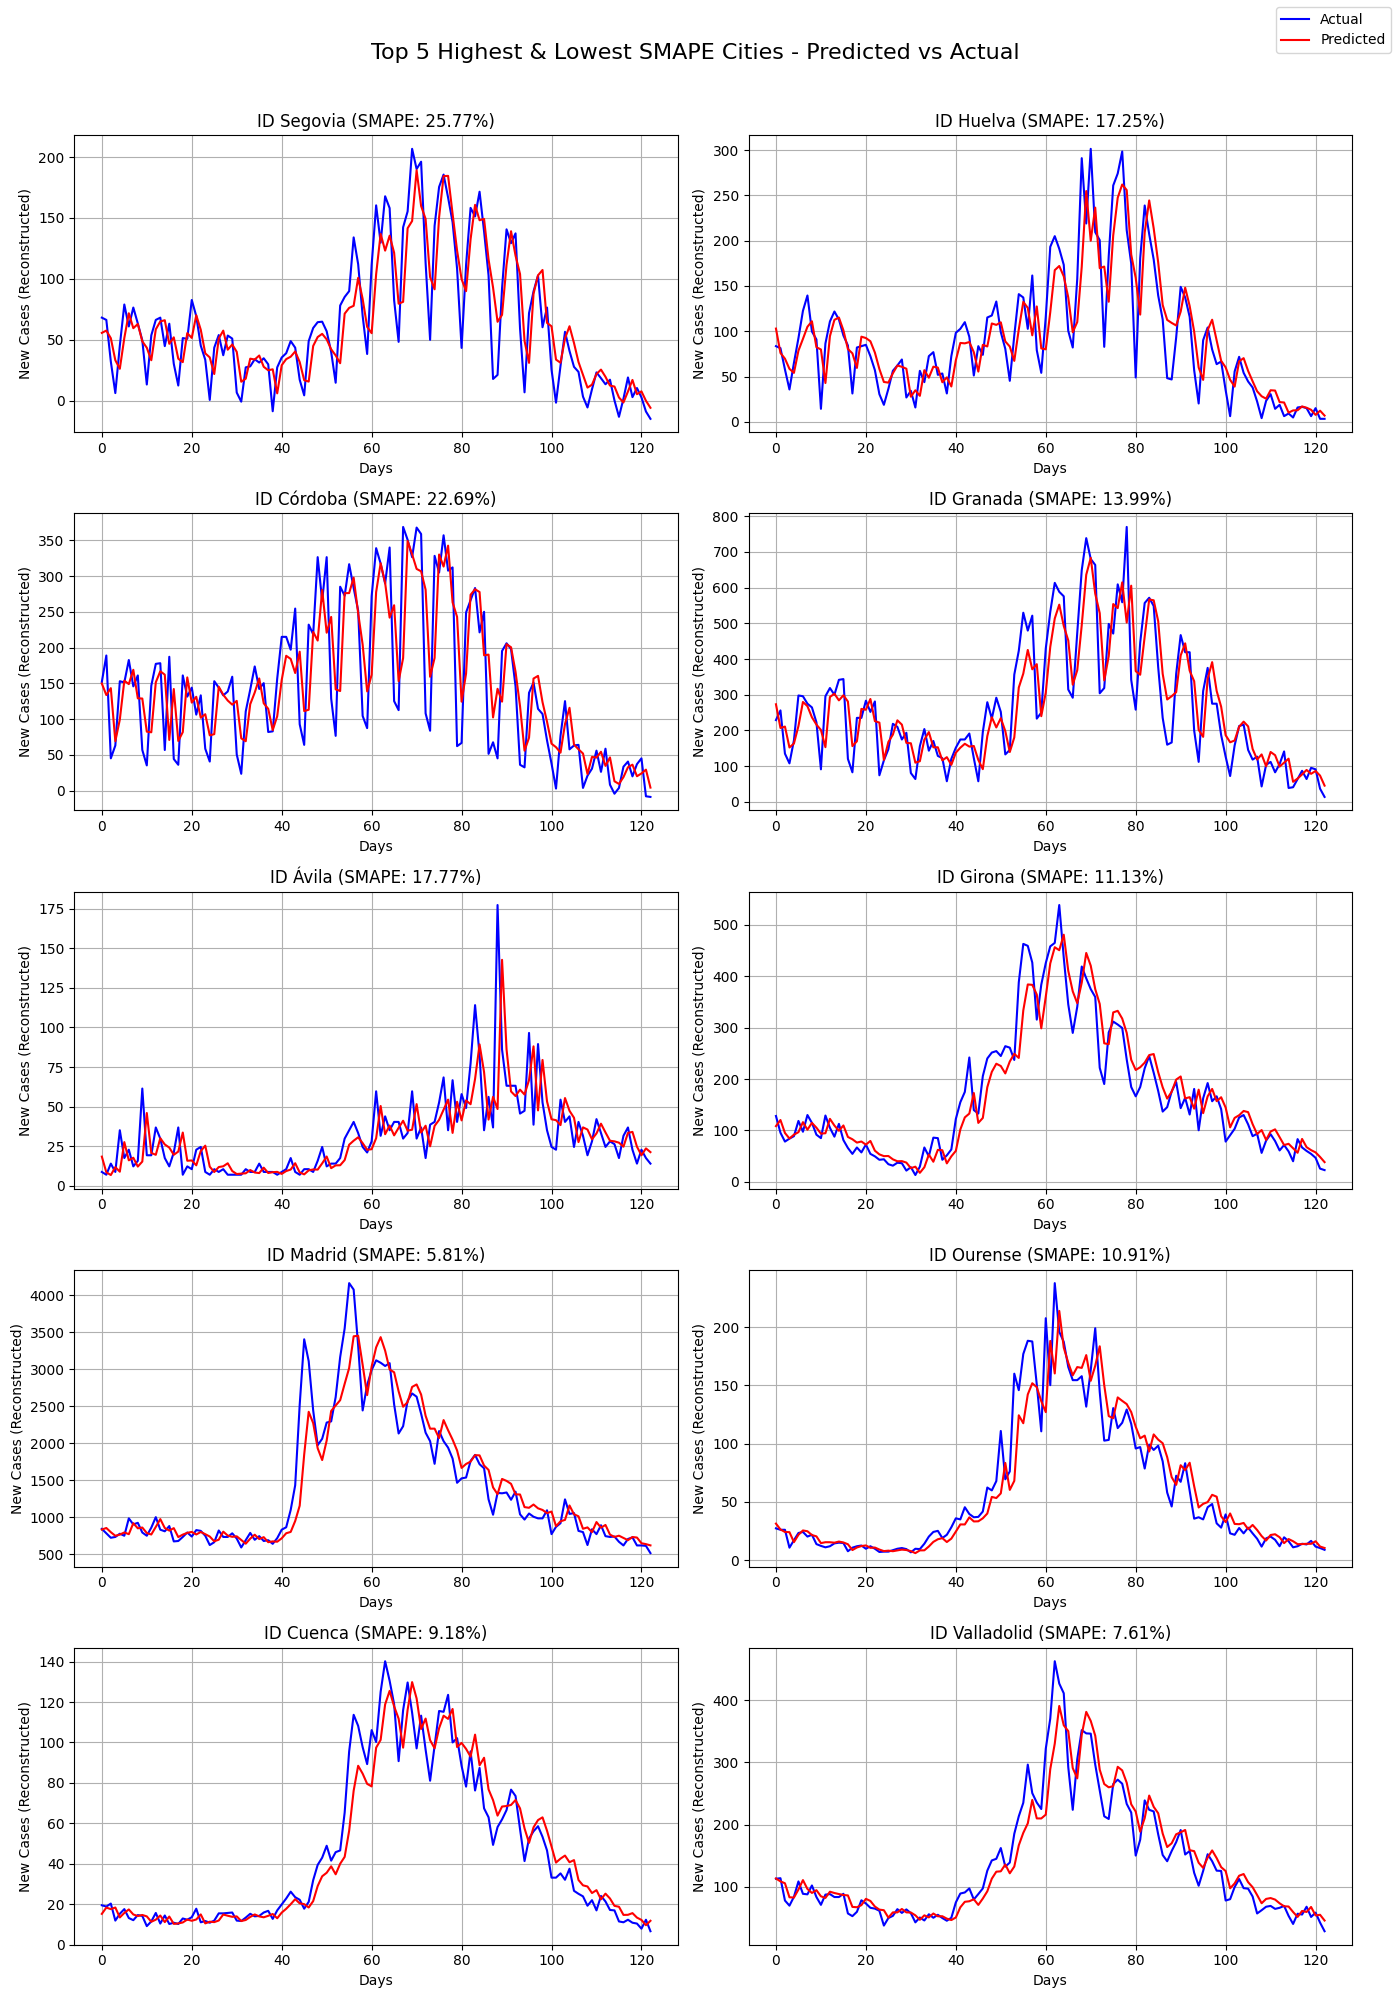

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 2: Compute SMAPE per city
city_smapes = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    smape_val = smape(actual, pred)
    city_smapes.append((city_id, smape_val))

# Step 3: Sort and get top 5 and bottom 5 by SMAPE
top_5_smape = sorted(city_smapes, key=lambda x: x[1], reverse=True)[:5]
bottom_5_smape = sorted(city_smapes, key=lambda x: x[1])[:5]

# Step 4: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 5: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = df_covid[df_covid['provincia'] == city_id].copy()
    city_data['Casos'] = city_data['Casos'].clip(lower=0)
    mean = city_data['Casos'].mean()
    std = city_data['Casos'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    smape_val = smape(actual, pred)
    ax.set_title(f"{city_name} (SMAPE: {smape_val:.2f}%)")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)

# Step 6: Plot all 10 cities (top 5 highest and lowest SMAPE)
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest SMAPE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5_smape + bottom_5_smape):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [141]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/GCN-GCN-Transformer-Spain-BEST-BEST.pth")

In [55]:
# Start with the last known input sequence (e.g., last batch or sample from X_test)
x_init = X_test_slide[-1].unsqueeze(0).to(device)  # [1, T, N, 1]

model.eval()
future_steps = 1
generated = []

with torch.no_grad():
    x_gen = x_init.clone()

    for step in range(future_steps):
        pred = model(x_gen, edge_index, edge_weight)  # [1, N, 1]
        generated.append(pred.squeeze(0).cpu())       # [N, 1]

        # Move window forward with the new prediction
        pred = pred.unsqueeze(1)  # [1, 1, N, 1]
        x_gen = torch.cat([x_gen[:, 1:], pred], dim=1)  # [1, T, N, 1]


# Stack predictions into [90, N]
generated = torch.cat(generated, dim=1)  # [N, 90]

historical = X_train_slide[-1].squeeze(-1).permute(1, 0)  # [N, T]

historical2 = X_test_slide[-1].squeeze(-1).permute(1, 0)  # [N, T]

print(sp_full.shape)

full_series = torch.cat([historical,historical2, generated], dim=1)  # [N, T + 90]
print(full_series.shape)

(786, 8)
torch.Size([52, 29])


/Users/youssefmalek/miniconda3/envs/ML/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


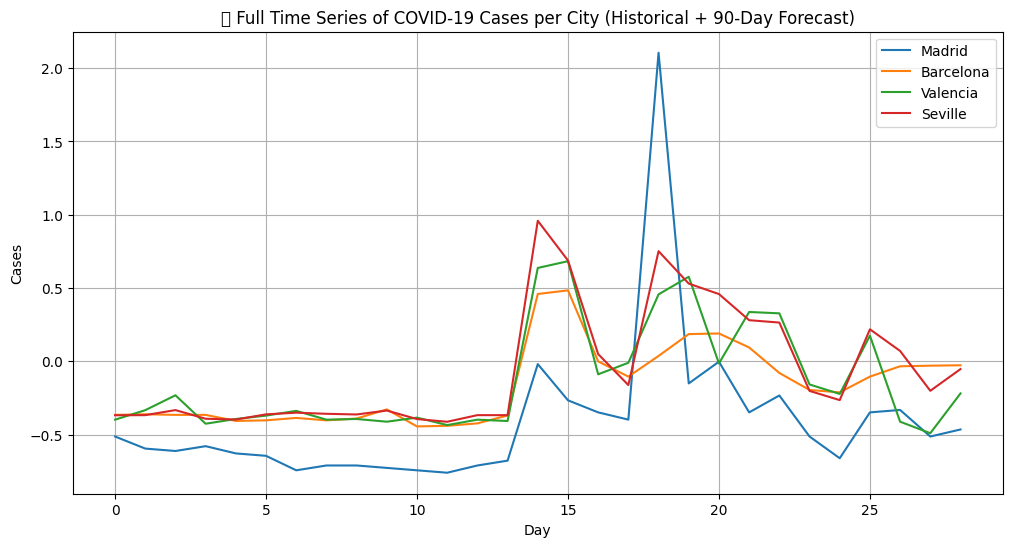

In [56]:
import matplotlib.pyplot as plt

city_names = ['Madrid', 'Barcelona', 'Valencia', 'Seville']  # adjust as needed
city_indices = [0, 1, 2, 3]  # corresponding indices in the data

plt.figure(figsize=(12, 6))
for idx, city in zip(city_indices, city_names):
    plt.plot(full_series[idx].numpy(), label=city)

plt.title("🔮 Full Time Series of COVID-19 Cases per City (Historical + 90-Day Forecast)")
plt.xlabel("Day")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()
